Contents produce no significant results — notebook can be ignored.

The first half of this notebook is similar to the systematic_variation.ipynb and can be skipped (i.e. no conclusive results). The second half starts with the box modifying the problem object in multi_condensed, to use "false eigenfunctions" instead. These eigenfunctions assume the same form as those in the typical MEEM formulation, but let d take on the value at whatever r it's being computed at, instead of being constant across the region. The results, while smooth, are visibly incorrect, and hydro-coefficients are far off.

In [ ]:
import sys
import os
sys.path.append(os.path.relpath('../../'))
import numpy as np
from multi_condensed import Problem
from math import sqrt, cosh, cos, sinh, sin, pi, exp
from scipy import integrate
import capytaine as cpt
import time

from scipy.special import iv as besseli
from scipy.special import kv as besselk
from scipy.special import ive as besselie
from scipy.special import kve as besselke
from numpy import inf

import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap


In [2]:
# Idea: Is there some kind of coupling between coefficients adjacent regions when doing slants?

# Regular variables
h = 100
d = [29, 7, 4]
a = [3, 5, 10]
heaving = [0, 1, 1] # 0/false if not heaving, 1/true if yes heaving
NMK = [50, 50, 50, 50]
m0 = 1
rho = 1023

# Define outline. Let the points defining it be exactly at the region boundaries.
d_in = [29, 29, 7] # depth on the inner edge of a region
d_out = [29, 7, 4] # depth on the outer edge of a region

for i in range(len(d)):
  if d_in[i] == d_out[i]: assert d_in[i] == d[i]
  # if a region is not slanted, its approximation isn't either.

# some  variables when running this in capytaine
t_densities = [40, 60, 110]
face_units = 130
reps = 1

In [3]:
# solve regular MEEM
def solve_MEEM(h, d, a, heaving, NMK, m0, rho):
  prob = Problem(h, d, a, heaving, NMK, m0, rho)
  a_matrix = prob.a_matrix()
  b_vector = prob.b_vector()
  x = prob.get_unknown_coeffs(a_matrix, b_vector)
  cs = prob.reformat_coeffs(x)
  am, dp = prob.hydro_coeffs(x, "capytaine")
  return prob, cs, am, dp

# get slope in each region.
def get_slopes(d_in, d_out, a):
  slopes = []
  for i in range(len(a)):
    if d_in[i] == d_out[i]:
      slopes.append(0)
    elif i == 0: # inner radius is 0
      slopes.append((d_in[i] - d_out[i])/a[i])
    else:
      slopes.append((d_in[i] - d_out[i])/(a[i] - a[i - 1]))
  return slopes

def make_slant_region(d1, d2, a1, a2, res):
  a_prime = []
  d_prime = []
  d_in_prime = []
  d_out_prime = []
  delta_d = (d2 - d1)/res
  delta_a = (a2 - a1)/res
  offset = (delta_d < 0)
  for i in range(res):
     a_prime.append(a1 + (1 + i) * delta_a)
     d_prime.append(d1 + (offset + i) * delta_d)
     d_in_prime.append(d1 + i * delta_d)
     d_out_prime.append(d1 + (1 + i) * delta_d)
  return a_prime, d_prime, d_in_prime, d_out_prime

# given an outline, create approximating box-MEEM inputs
def slant_approx_vars(a, d_in, d_out, heaving, NMK, res):
  a_prime = []
  d_prime = []
  d_in_prime = []
  d_out_prime = []
  heaving_prime = []
  NMK_prime = []
  for i in range(len(a)):
    if d_in[i] == d_out[i]: # horizontal region
        a_prime.append(a[i])
        d_prime.append(d_in[i])
        d_in_prime.append(d_in[i])
        d_out_prime.append(d_in[i])
        heaving_prime.append(heaving[i])
        NMK_prime.append(NMK[i])
    else: # slanted region
       heaving_prime += ([heaving[i]] * res)
       NMK_prime += ([NMK[i]] * res)
       a_inner = 0 if i == 0 else a[i - 1]
       a_add, d_add, d_in_add, d_out_add = make_slant_region(d_in[i], d_out[i], a_inner, a[i], res)
       a_prime += a_add
       d_prime += d_add
       d_in_prime += d_in_add
       d_out_prime += d_out_add
  NMK_prime.append(NMK[-1])
  return a_prime, d_prime, d_in_prime, d_out_prime, heaving_prime, NMK_prime

In [9]:
res = 40
a_prime, d_prime, d_in_prime, d_out_prime, heaving_prime, NMK_prime = slant_approx_vars(a, d_in, d_out, heaving, NMK, res)
prob1, cs1, am1, dp1 = solve_MEEM(h, d_prime, a_prime, heaving_prime, NMK_prime, m0, rho)
slopes1 = get_slopes( d_in_prime, d_out_prime, a_prime)

print("Added Mass:", am1)
print("Damping:", dp1)


Added Mass: 937128.033505392
Damping: 125.00962529625448


In [38]:
# regions of interest: 1 - 40
regions = range(1, res + 1)
i_type = np.zeros((res, NMK[1]), dtype=complex)
k_type = np.zeros((res, NMK[1]), dtype=complex)

for region in regions:
  for m in range(NMK[1]):
    i_type[region - 1, m] = cs1[region][m]
    k_type[region - 1, m] = cs1[region][m + NMK[1]]

(-2.4326439496722414+7.808411671376765e-07j) (-2.4326439496722414+7.808411671376765e-07j)


In [ ]:
def plot_m_region(arr, m, regions, bessel_type):
  plt.plot(regions, arr[:, m], color = "red")
  # Labels and title
  plt.xlabel('region #')
  plt.ylabel('value')
  plt.title('value of coefficient of ' + str(m) + 'th bessel function of type ' + bessel_type)
  plt.grid(True)
  plt.tight_layout()
  plt.show()

/Users/Bimali/Desktop/SEALab/semi-analytical-hydro/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/Bimali/Desktop/SEALab/semi-analytical-hydro/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


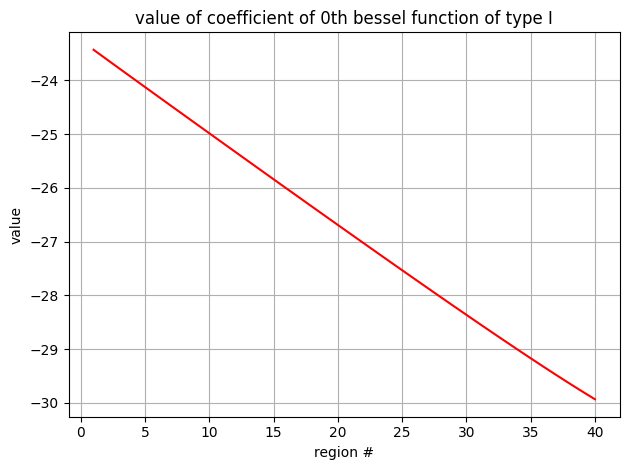

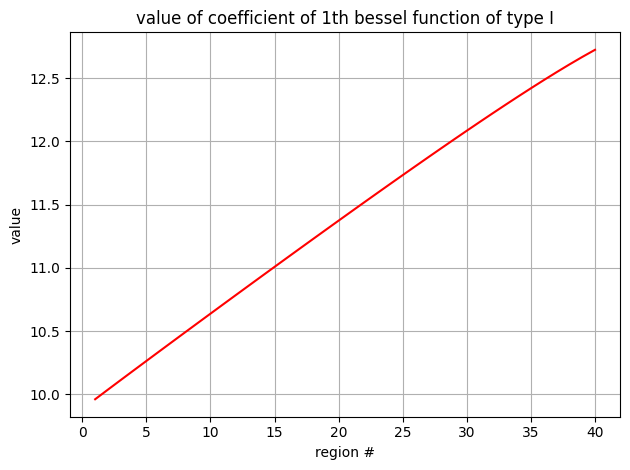

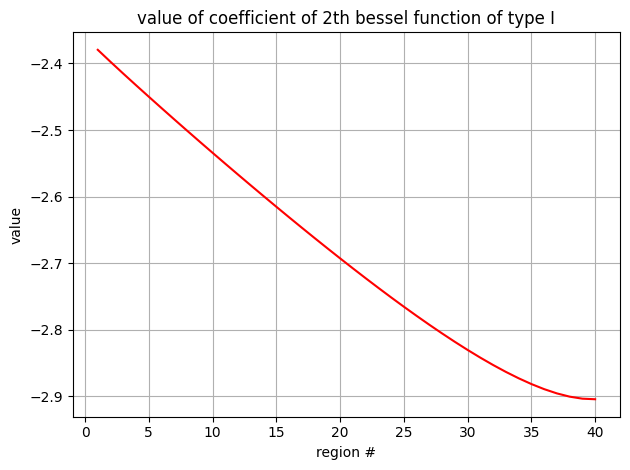

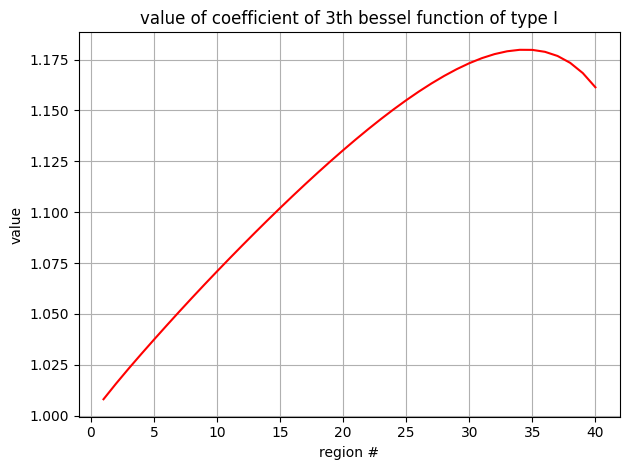

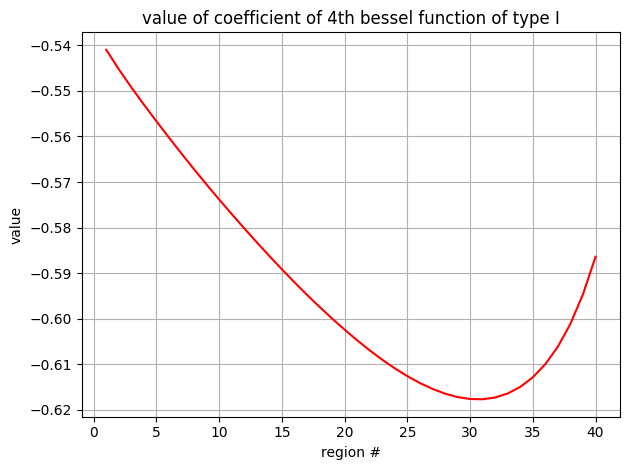

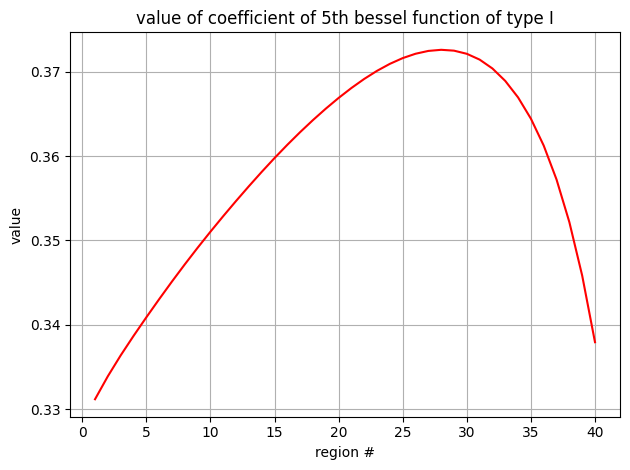

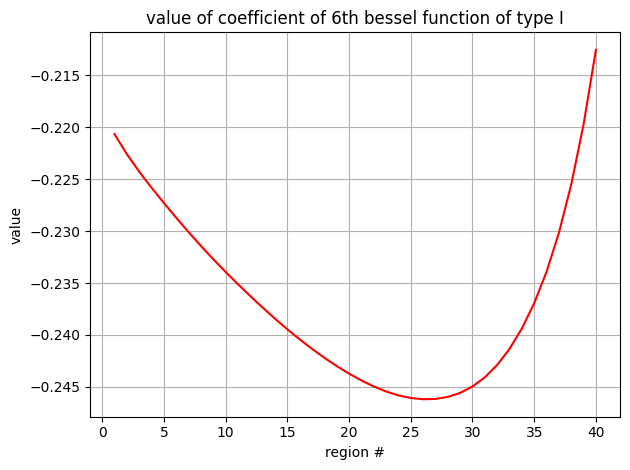

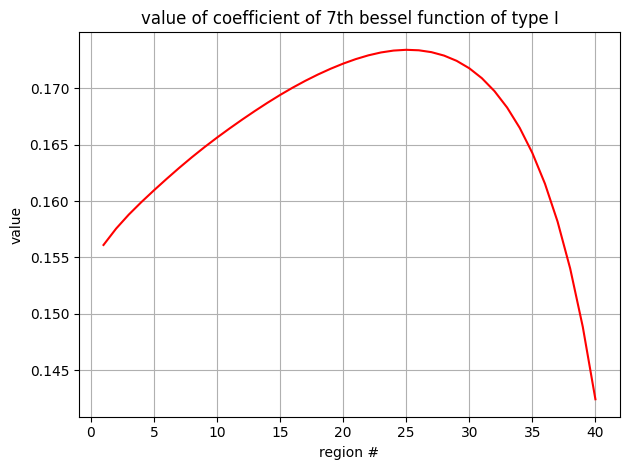

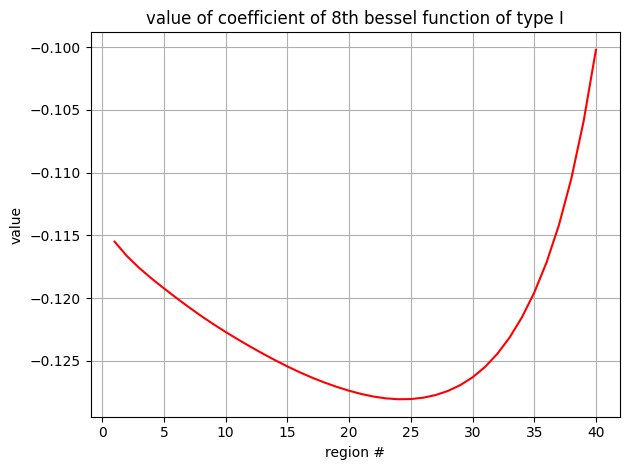

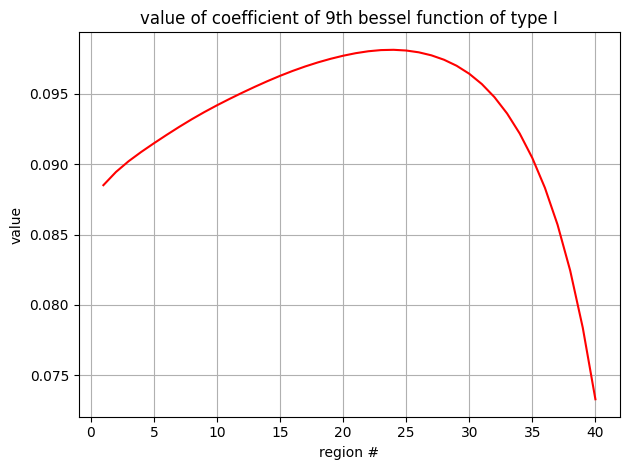

In [41]:
for m in range(10):
  plot_m_region(i_type, m, regions, "I")

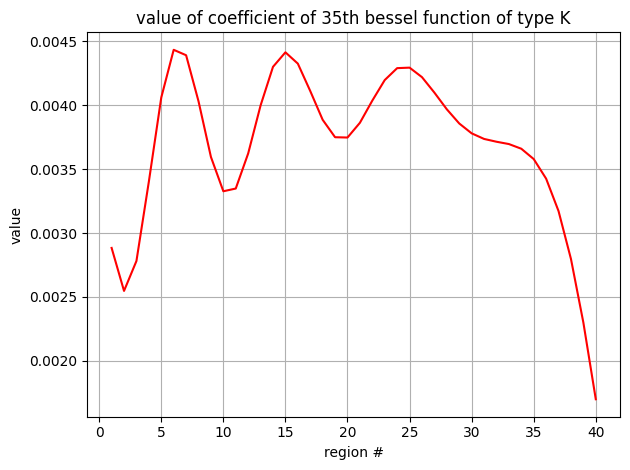

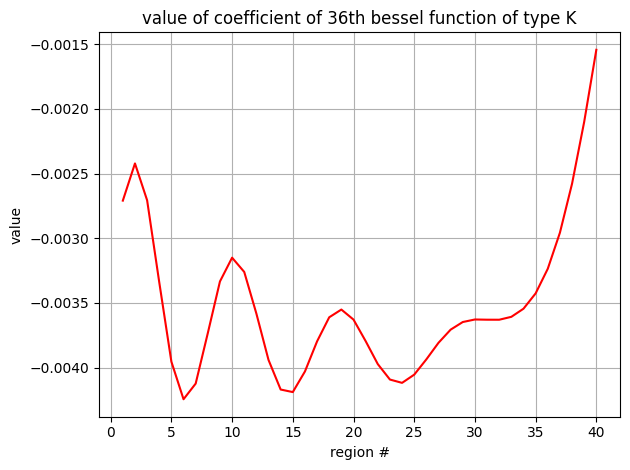

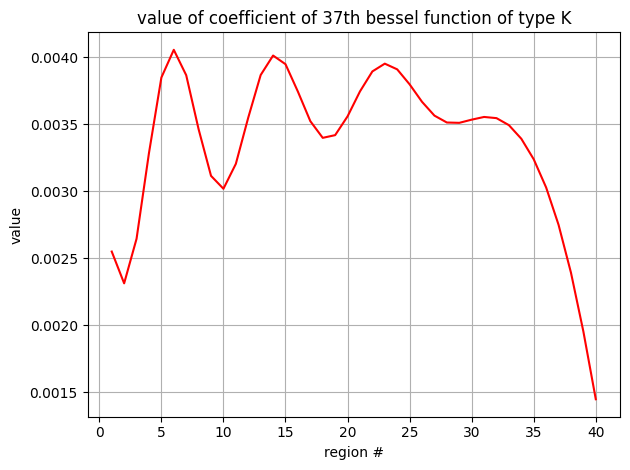

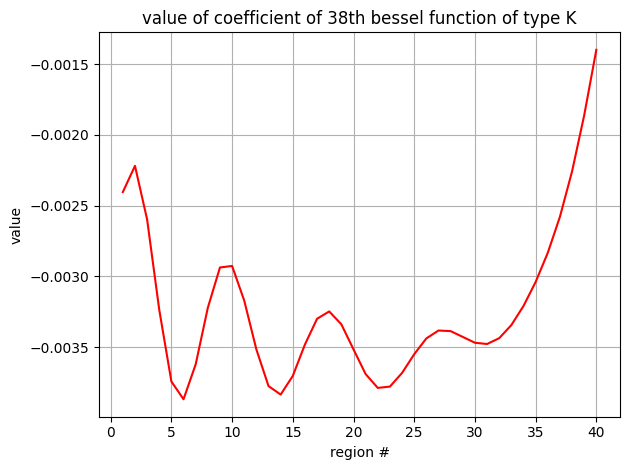

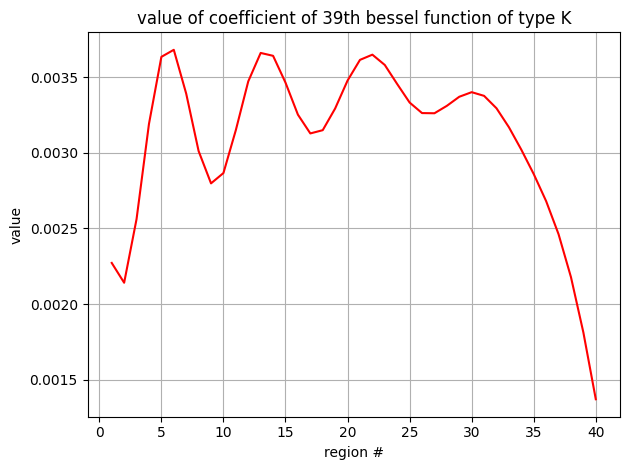

In [43]:
for m in range(35, 40):
  plot_m_region(k_type, m, regions, "K")

/var/folders/zz/_5443rfn2v1_n4x4gqlv6jxc0000gr/T/ipykernel_51087/64337882.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('Blues')


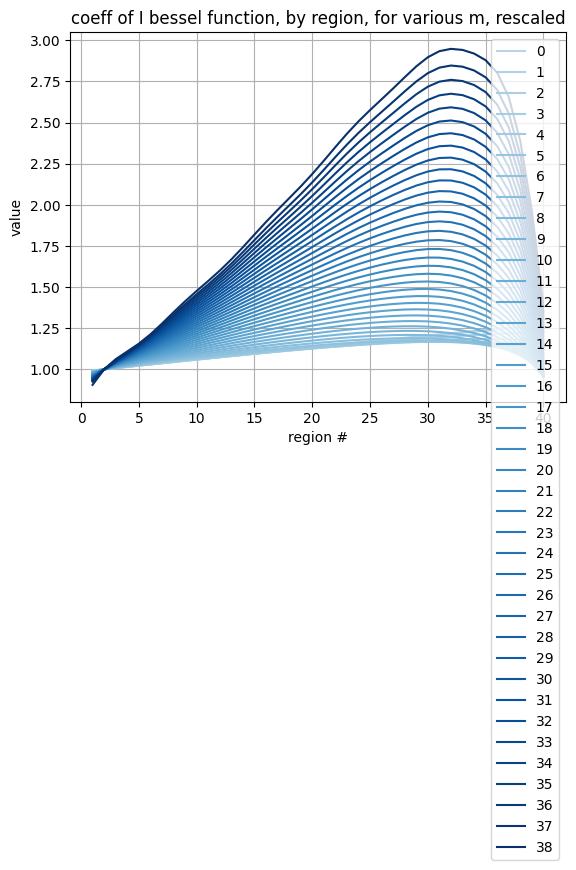

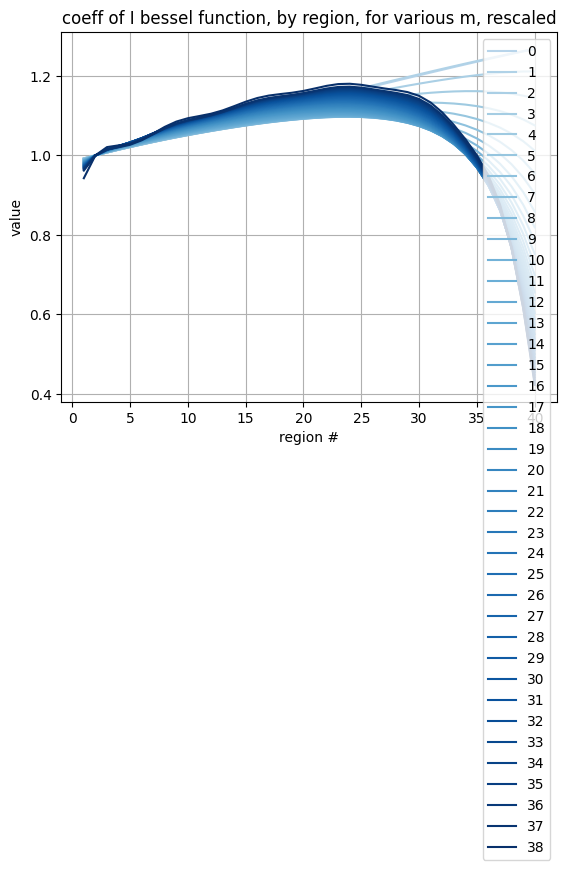

In [80]:
scale_by_function_scaling_i1 = lambda i, m, x: (besseli(0, prob1.lambda_ni(m, i) * a_prime[i]) * x)/(besseli(0, prob1.lambda_ni(m, 1) * a_prime[1]) * i_type[1][m])
scale_by_function_scaling_i2 = lambda i, m, x: x/i_type[1][m]
i_type_scaled1 = np.array([[scale_by_function_scaling_i1(i, j, val) for j, val in enumerate(row)]
                    for i, row in enumerate(i_type)])
i_type_scaled2 = np.array([[scale_by_function_scaling_i2(i, j, val) for j, val in enumerate(row)]
                    for i, row in enumerate(i_type)])

def plot_many_scaled(arr, regions, coeff_range, bessel_type):
  cmap = get_cmap('Blues')
  interval = 0.7/coeff_range[-1]
  colors = [cmap(0.3 + interval * i) for i in coeff_range]
  for m in coeff_range:
    plt.plot(regions, arr [:, m], color = colors[m], label = str(m))
  # Labels and title
  plt.xlabel('region #')
  plt.ylabel('value')
  plt.legend()
  plt.title('coeff of ' + bessel_type + ' bessel function, by region, for various m, rescaled')
  plt.grid(True)
  plt.show()

plot_many_scaled(i_type_scaled1, regions, range(39), "I")
plot_many_scaled(i_type_scaled2, regions, range(39), "I")
# looks bad for m >= 39. Why?
# can we ignore this?

/var/folders/zz/_5443rfn2v1_n4x4gqlv6jxc0000gr/T/ipykernel_51087/518466683.py:1: RuntimeWarning: invalid value encountered in scalar multiply
  scale_by_function_scaling_k1 = lambda i, m, x: (besselk(0, prob1.lambda_ni(m, i) * a_prime[i]) * x)/(besselk(0, prob1.lambda_ni(m, 1) * a_prime[1]) * k_type[1][m])
/var/folders/zz/_5443rfn2v1_n4x4gqlv6jxc0000gr/T/ipykernel_51087/518466683.py:1: RuntimeWarning: invalid value encountered in scalar divide
  scale_by_function_scaling_k1 = lambda i, m, x: (besselk(0, prob1.lambda_ni(m, i) * a_prime[i]) * x)/(besselk(0, prob1.lambda_ni(m, 1) * a_prime[1]) * k_type[1][m])
/var/folders/zz/_5443rfn2v1_n4x4gqlv6jxc0000gr/T/ipykernel_51087/64337882.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('Blues')


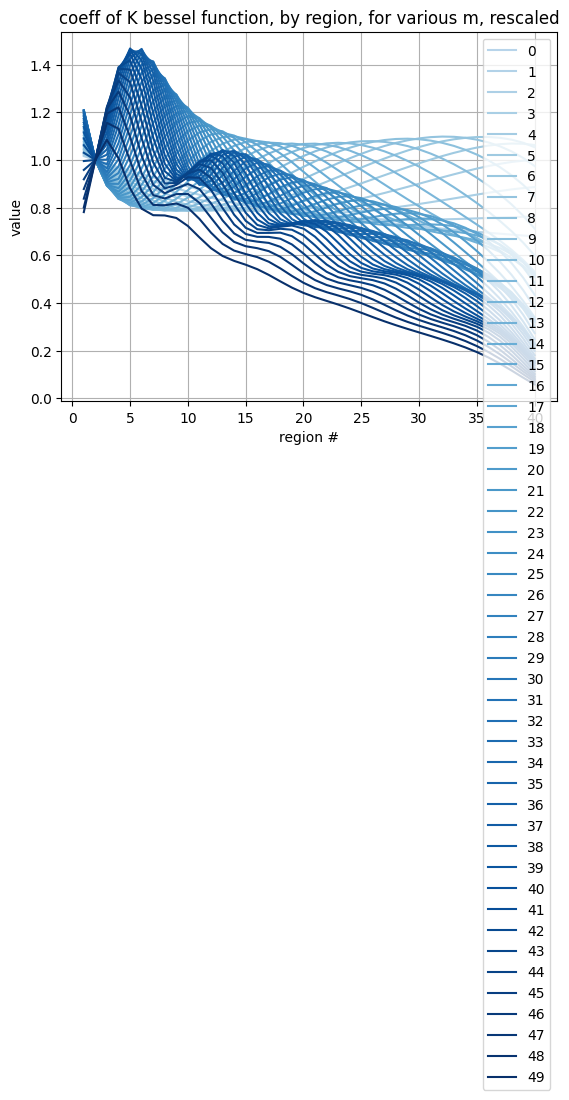

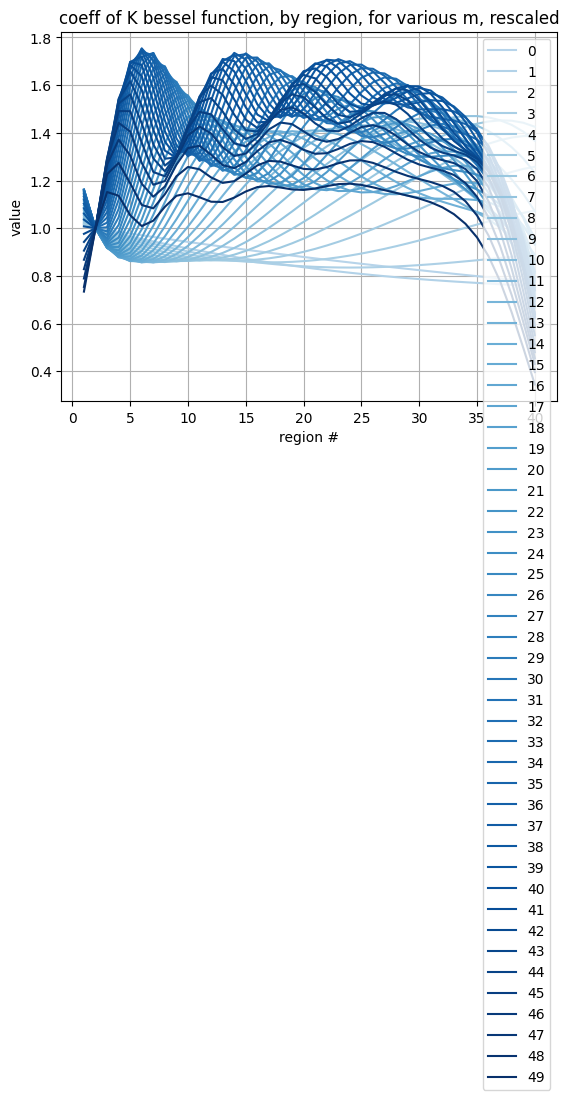

In [81]:
scale_by_function_scaling_k1 = lambda i, m, x: (besselk(0, prob1.lambda_ni(m, i) * a_prime[i]) * x)/(besselk(0, prob1.lambda_ni(m, 1) * a_prime[1]) * k_type[1][m])
k_type_scaled1 = np.array([[scale_by_function_scaling_k1(i, j, val) for j, val in enumerate(row)]
                    for i, row in enumerate(k_type)])

scale_by_function_scaling_k2 = lambda i, m, x: (x)/(k_type[1][m])
k_type_scaled2 = np.array([[scale_by_function_scaling_k2(i, j, val) for j, val in enumerate(row)]
                    for i, row in enumerate(k_type)])

plot_many_scaled(k_type_scaled1, regions, range(50), "K")
plot_many_scaled(k_type_scaled2, regions, range(50), "K")

/var/folders/zz/_5443rfn2v1_n4x4gqlv6jxc0000gr/T/ipykernel_51087/1764947426.py:13: RuntimeWarning: invalid value encountered in scalar multiply
  scale_by_function_scaling2_k1 = lambda i, m, x: (besselk(0, prob1.lambda_ni(m, i + 41) * a_prime[i + 41]) * x)/(besselk(0, prob1.lambda_ni(m, 41) * a_prime[41]) * k_type2[1][m])
/var/folders/zz/_5443rfn2v1_n4x4gqlv6jxc0000gr/T/ipykernel_51087/1764947426.py:13: RuntimeWarning: invalid value encountered in scalar divide
  scale_by_function_scaling2_k1 = lambda i, m, x: (besselk(0, prob1.lambda_ni(m, i + 41) * a_prime[i + 41]) * x)/(besselk(0, prob1.lambda_ni(m, 41) * a_prime[41]) * k_type2[1][m])
/var/folders/zz/_5443rfn2v1_n4x4gqlv6jxc0000gr/T/ipykernel_51087/64337882.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('Blues')


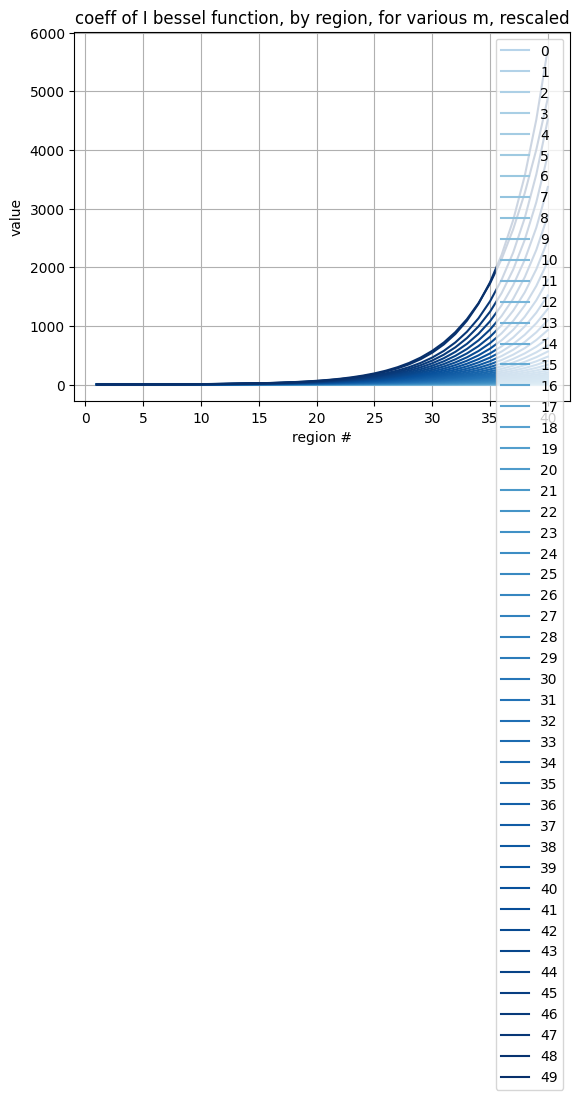

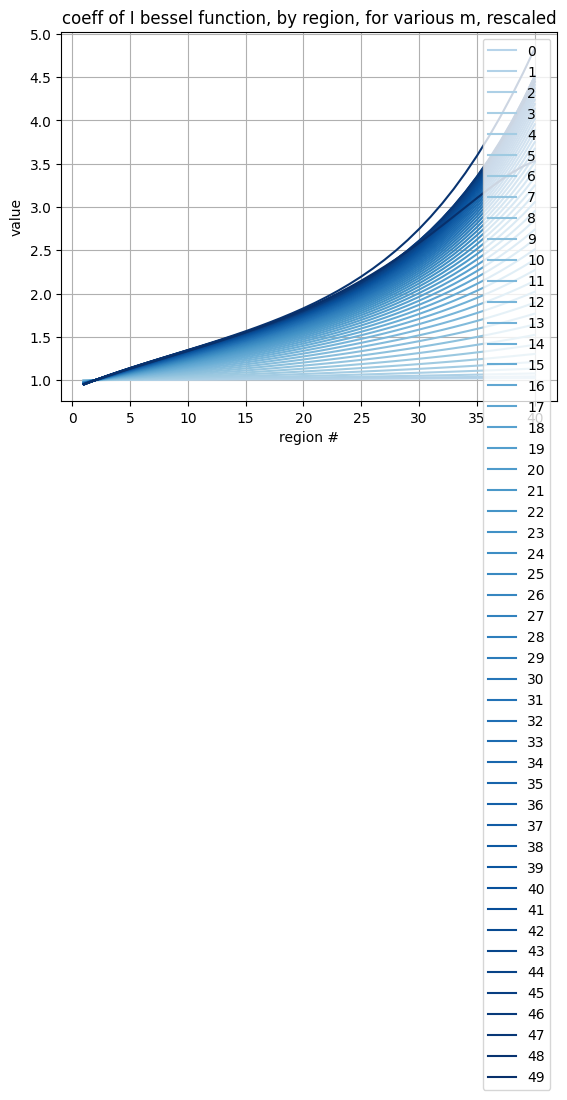

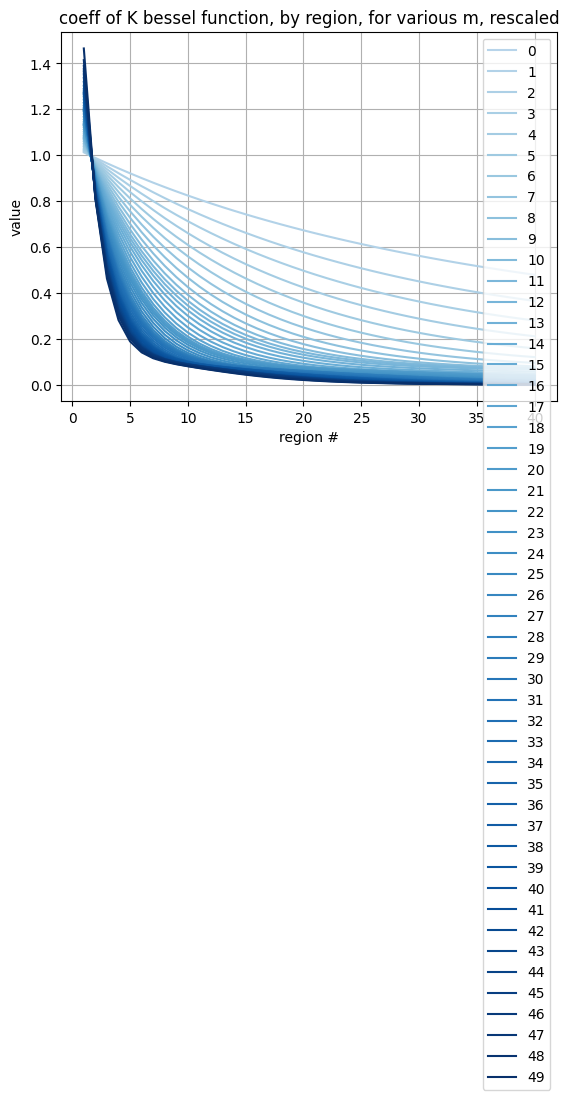

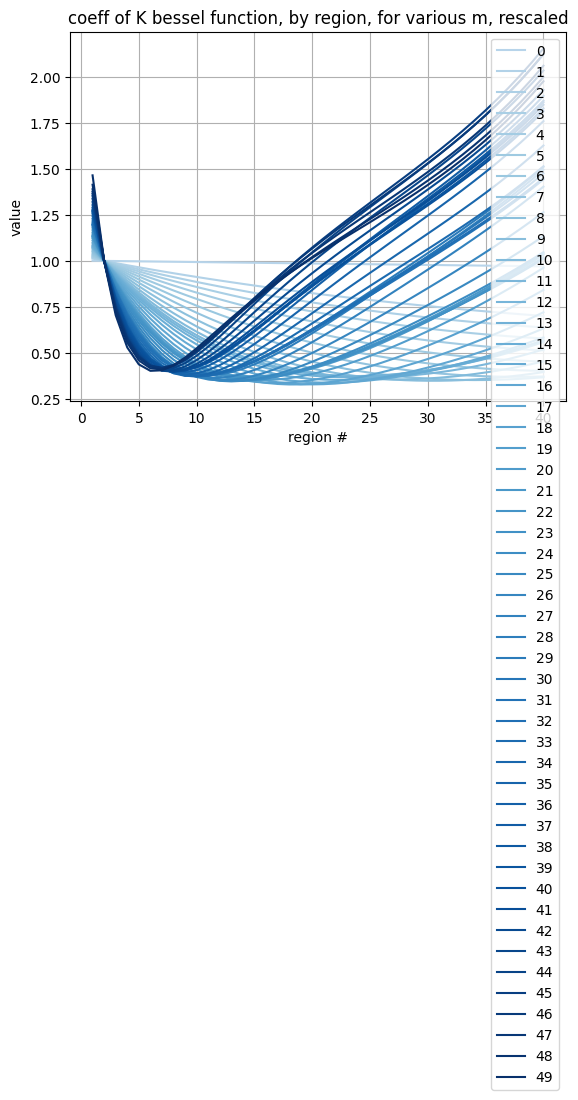

In [94]:
# regions of interest: 1 - 40
regions = range(1, res + 1)
i_type2 = np.zeros((res, NMK[2]), dtype=complex)
k_type2 = np.zeros((res, NMK[2]), dtype=complex)

for region in regions:
  for m in range(NMK[2]):
    i_type2[region - 1, m] = cs1[region + 40][m]
    k_type2[region - 1, m] = cs1[region + 40][m + NMK[2]]

scale_by_function_scaling2_i1 = lambda i, m, x: (besseli(0, prob1.lambda_ni(m, i + 41) * a_prime[i + 41]) * x)/(besseli(0, prob1.lambda_ni(m, 41) * a_prime[41]) * i_type2[1][m])
scale_by_function_scaling2_i2 = lambda i, m, x: x/i_type2[1][m]
scale_by_function_scaling2_k1 = lambda i, m, x: (besselk(0, prob1.lambda_ni(m, i + 41) * a_prime[i + 41]) * x)/(besselk(0, prob1.lambda_ni(m, 41) * a_prime[41]) * k_type2[1][m])
scale_by_function_scaling2_k2 = lambda i, m, x: (x)/(k_type2[1][m])
i_type2_scaled1 = np.array([[scale_by_function_scaling2_i1(i, j, val) for j, val in enumerate(row)]
                    for i, row in enumerate(i_type2)])
i_type2_scaled2 = np.array([[scale_by_function_scaling2_i2(i, j, val) for j, val in enumerate(row)]
                    for i, row in enumerate(i_type2)])
k_type2_scaled1 = np.array([[scale_by_function_scaling2_k1(i, j, val) for j, val in enumerate(row)]
                    for i, row in enumerate(k_type2)])
k_type2_scaled2 = np.array([[scale_by_function_scaling2_k2(i, j, val) for j, val in enumerate(row)]
                    for i, row in enumerate(k_type2)])
plot_many_scaled(i_type2_scaled1, regions, range(50), "I")
plot_many_scaled(i_type2_scaled2, regions, range(50), "I")
plot_many_scaled(k_type2_scaled1, regions, range(50), "K")
plot_many_scaled(k_type2_scaled2, regions, range(50), "K")


In [196]:
# Define a new eigenfunctions for the slanted region
# Exactly the same as the old ones but "d" is now dependent on r in lambda_ni
# Also d is now split into d_in and d_out.
# Replace all functions related to this.

class SProblem(Problem):
    # get slope in each region.
    def __init__(self, h, d_in, d_out, a, heaving, NMK, m0, rho, scale = None):
        self.h = h
        self.d_in = d_in
        self.d_out = d_out
        self.a = a
        self.heaving = heaving
        self.NMK = NMK
        self.m0 = m0
        self.rho = rho
        self.scale = a if scale is None else scale
        self.size = NMK[0] + NMK[-1] + 2 * sum(NMK[1:len(NMK) - 1])
        self.boundary_count = len(NMK) - 1
        self.m_k = self.m_k_array()
        self.slopes = self.get_slopes()

    def get_slopes(self):
        a, d_in, d_out = self.a, self.d_in, self.d_out
        slopes = []
        for i in range(len(a)):
            if d_in[i] == d_out[i]:
                slopes.append(0)
            elif i == 0: # inner radius is 0
                slopes.append((d_out[i] - d_in[i])/a[i])
            else:
                slopes.append((d_out[i] - d_in[i])/(a[i] - a[i - 1]))
        return slopes
        
    def det_region(self, r):
        region = 0
        for i in range(self.boundary_count):
            if r <= self.a[i]:
                return region
            else: region += 1
        return region

    def d(self, r, i): # i is region
        d_in, d_out = self.d_in, self.d_out
        if d_in[i] == d_out[i]:
            return d_in[i]
        else:
            return self.slopes[i] * (r - self.a[i]) + d_out[i]

    def lambda_ni(self, n, i, r): # factor used often in calculations
        return n * pi / (self.h - self.d(r, i))
        #############################################
        # vertical eigenvector coupling computation
    def I_nm(self, n, m, i): # coupling integral for two i-type regions
        h, a = self.h, self.a
        d_in, d_out = self.d_in, self.d_out
        dj = max(d_out[i], d_in[i+1]) # integration bounds at -h and -d
        if n == 0 and m == 0:
            return h - dj
        lambda1 = self.lambda_ni(n, i, a[i])
        lambda2 = self.lambda_ni(m, i + 1, a[i])
        if n == 0 and m >= 1:
            if dj == d_in[i+1]:
                return 0
            else:
                return sqrt(2) * sin(lambda2 * (h - dj)) / lambda2
        if n >= 1 and m == 0:
            if dj == d_out[i]:
                return 0
            else:
                return sqrt(2) * sin(lambda1 * (h - dj)) / lambda1
        else:
            frac1 = sin((lambda1 + lambda2)*(h-dj))/(lambda1 + lambda2)
            if lambda1 == lambda2:
                frac2 = (h - dj)
            else:
                frac2 = sin((lambda1 - lambda2)*(h-dj))/(lambda1 - lambda2)
            return frac1 + frac2

    def I_mk(self, m, k, i): # coupling integral for i and e-type regions
        h, m0, m_k, N_k = self.h, self.m0, self.m_k, self.N_k
        dj = self.d_out[i]
        if m == 0 and k == 0:
            if m0 == inf: return 0
            elif m0 * h < 14:
                return (1/sqrt(N_k(0))) * sinh(m0 * (h - dj)) / m0
            else: # high m0h approximation
                return sqrt(2 * h / m0) * (exp(- m0 * dj) - exp(m0 * dj - 2 * m0 * h))
        if m == 0 and k >= 1:
            return (1/sqrt(N_k(k))) * sin(m_k[k] * (h - dj)) / m_k[k]
        if m >= 1 and k == 0:
            if m0 == inf: return 0
            elif m0 * h < 14:
                num = (-1)**m * sqrt(2) * (1/sqrt(N_k(0))) * m0 * sinh(m0 * (h - dj))
            else: # high m0h approximation
                num = (-1)**m * 2 * sqrt(h * m0 ** 3) *(exp(- m0 * dj) - exp(m0 * dj - 2 * m0 * h))
            denom = (m0**2 + self.lambda_ni(m, i, self.a[i]) **2)
            return num/denom
        else:
            lambda1 = self.lambda_ni(m, i, self.a[i])
            if abs(m_k[k]) == lambda1:
                return sqrt(2/N_k(k)) * (h - dj)/2
            else:
                frac1 = sin((m_k[k] + lambda1)*(h-dj))/(m_k[k] + lambda1)
                frac2 = sin((m_k[k] - lambda1)*(h-dj))/(m_k[k] - lambda1)
                return sqrt(2/N_k(k)) * (frac1 + frac2)/2

    def b_vector(self):
        b = np.zeros(self.size, dtype=complex)
        index = 0
        d_in, d_out, boundary_count, NMK = self.d_in, self.d_out, self.boundary_count, self.NMK

        # potential matching
        for boundary in range(boundary_count):
            if boundary == (boundary_count - 1): # i-e boundary
                for n in range(NMK[-2]):
                    b[index] = self.b_potential_end_entry(n, boundary)
                    index += 1
            else: # i-i boundary
                for n in range(self.NMK[boundary + (d_out[boundary] <= d_in[boundary + 1])]): # iterate over eigenfunctions for smaller h-d
                    b[index] = self.b_potential_entry(n, boundary)
                    index += 1

        # velocity matching
        for boundary in range(boundary_count):
            if boundary == (boundary_count - 1): # i-e boundary
                for n in range(NMK[-1]):
                    b[index] = self.b_velocity_end_entry(n, boundary)
                    index += 1
            else: # i-i boundary
                for n in range(NMK[boundary + (d_out[boundary] > d_in[boundary + 1])]): # iterate over eigenfunctions for larger h-d
                    b[index] = self.b_velocity_entry(n, boundary)
                    index += 1
        return b

    def b_potential_entry(self, n, i): # for two i-type regions
        #(integrate over shorter fluid, use shorter fluid eigenfunction)
        h, d_out, d_in, a, heaving = self.h, self.d_out, self.d_in, self.a, self.heaving
        if d_out[i] <= d_in[i + 1]: # find shorter fluid
            j = i + 1
            dj = d_in[j]
        else:
            j = i
            dj = d_out[j]
        constant = (heaving[i+1] / (h - d_in[i+1]) - heaving[i] / (h - d_out[i]))
        if n == 0:
            return constant * 1/2 * ((h - dj)**3/3 - (h-dj) * a[i]**2/2)
        else:
            return sqrt(2) * (h - dj) * constant * ((-1) ** n)/(self.lambda_ni(n, j, a[i]) ** 2)

    def b_potential_end_entry(self, n, i): # between i and e-type regions
        h, d_out, a, heaving = self.h, self.d_out, self.a, self.heaving
        constant = - heaving[i] / (h - d_out[i])
        if n == 0:
            return constant * 1/2 * ((h - d_out[i])**3/3 - (h-d_out[i]) * a[i]**2/2)
        else:
            return sqrt(2) * (h - d_out[i]) * constant * ((-1) ** n)/(self.lambda_ni(n, i, a[i]) ** 2)

    def b_velocity_entry(self, n, i): # for two i-type regions
        h, d_out, d_in, a, heaving = self.h, self.d_out, self.d_in, self.a, self.heaving
        if n == 0:
            return (heaving[i+1] - heaving[i]) * (a[i]/2)
        if d_out[i] > d_in[i + 1]: #using i+1's vertical eigenvectors
            if heaving[i]:
                num = - sqrt(2) * a[i] * sin(self.lambda_ni(n, i+1, a[i]) * (h-d_out[i]))
                denom = (2 * (h - d_out[i]) * self.lambda_ni(n, i+1, a[i]))
                return num/denom
            else: return 0
        else: #using i's vertical eigenvectors
            if heaving[i+1]:
                num = sqrt(2) * a[i] * sin(self.lambda_ni(n, i, a[i]) * (h-d_in[i+1]))
                denom = (2 * (h - d_in[i+1]) * self.lambda_ni(n, i, a[i]))
                return num/denom
            else: return 0

    def b_velocity_end_entry(self, k, i): # between i and e-type regions
        h, d_out, a, heaving, m0, m_k = self.h, self.d_out, self.a, self.heaving, self.m0, self.m_k
        constant = - heaving[i] * a[i]/(2 * (h - d_out[i]))
        if k == 0:
            if m0 == inf: return 0
            elif m0 * h < 14:
                return constant * (1/sqrt(self.N_k(0))) * sinh(m0 * (h - d_out[i])) / m0
            else: # high m0h approximation
                return constant * sqrt(2 * h / m0) * (exp(- m0 * d_out[i]) - exp(m0 * d_out[i] - 2 * m0 * h))
        else:
            return constant * (1/sqrt(self.N_k(k))) * sin(m_k[k] * (h - d_out[i])) / m_k[k]

    #############################################
    # Eigenfunctions and derivatives, inner regions
    # The "Bessel I" radial eigenfunction
    def R_1n(self, n, r, i):
        scale, lambda_ni = self.scale, self.lambda_ni
        if n == 0:
            return 0.5
        elif n >= 1:
            if r == scale[i]:
                return 1
            else:
                return besselie(0, lambda_ni(n, i, r) * r) / besselie(0, lambda_ni(n, i, r) * scale[i]) * exp(lambda_ni(n, i, r) * r - lambda_ni(n, i, scale[i]) * scale[i])
        else: 
            raise ValueError("Invalid value for n")

    # Bessel I, differentiated wrt r
    def diff_R_1n(self, n, r, i):
        scale, lambda_ni = self.scale, self.lambda_ni
        if n == 0:
            return 0
        else:
            top = lambda_ni(n, i, r) * besselie(1, lambda_ni(n, i, r) * r)
            bottom = besselie(0, lambda_ni(n, i, scale[i]) * scale[i])
            return top / bottom * exp(lambda_ni(n, i, r) * r - lambda_ni(n, i, scale[i]) * scale[i])

    # The "Bessel K" radial eigenfunction
    def R_2n(self, n, r, i):
        scale, lambda_ni = self.scale, self.lambda_ni
        if i == 0:
            raise ValueError("i cannot be 0")  # this shouldn't be called for i=0, innermost region.
        elif n == 0:
            return 0.5 * np.log(r / self.a[i])
        else:
            if r == scale[i]:
                return 1
            else:
                return besselke(0, lambda_ni(n, i, r) * r) / besselke(0, lambda_ni(n, i, scale[i]) * scale[i]) * exp(lambda_ni(n, i, scale[i]) * scale[i] - lambda_ni(n, i, r) * r)

    # Bessel K, differentiated wrt r
    def diff_R_2n(self, n, r, i):
        scale, lambda_ni = self.scale, self.lambda_ni
        if n == 0:
            return 1 / (2 * r)
        else:
            top = - lambda_ni(n, i, r) * besselke(1, lambda_ni(n, i, r) * r)
            bottom = besselke(0, lambda_ni(n, i, scale[i]) * scale[i])
            return top / bottom * exp(lambda_ni(n, i, scale[i]) * scale[i] - lambda_ni(n, i, r) * r)

    # i-region vertical eigenfunction
    def Z_n_i(self, n, z, i, r):
        if n == 0:
            return 1
        else:
            return np.sqrt(2) * np.cos(self.lambda_ni(n, i, r) * (z + self.h))

    # i-region vertical eigenfunction, differentiated wrt z
    def diff_Z_n_i(self, n, z, i, r):
        if n == 0:
            return 0
        else:
            lambda0 = self.lambda_ni(n, i, r)
            return - lambda0 * np.sqrt(2) * np.sin(lambda0 * (z + self.h))
        
    def p_diagonal_block(self, left, radfunction, bd):
        h, a, NMK = self.h, self.a, self.NMK
        if left:
            region = bd
            depth = self.d_out[region]
        else:
            region = bd + 1
            depth = self.d_in[region]
        sign = 1 if left else (-1)
        return sign * (h - depth) * np.diag(radfunction(list(range(NMK[region])), a[bd], region))

    def v_diagonal_block(self, left, radfunction, bd):
        h, a, NMK = self.h, self.a, self.NMK
        if left:
            region = bd
            depth = self.d_out[region]
        else:
            region = bd + 1
            depth = self.d_in[region]
        sign = (-1) if left else (1)
        return sign * (h - depth) * np.diag(radfunction(list(range(NMK[region])), a[bd], region))

    # A matrix calculations
    def a_matrix(self):
        d_in, d_out, NMK, boundary_count, size = self.d_in, self.d_out, self.NMK, self.boundary_count, self.size
        # localize eigenfunctions
        R_1n, R_2n, diff_R_1n, diff_R_2n = self.R_1n, self.R_2n, self.diff_R_1n, self.diff_R_2n
        # localize block functions
        p_diagonal_block = self.p_diagonal_block
        p_dense_block, p_dense_block_e = self.p_dense_block, self.p_dense_block_e
        v_diagonal_block, v_diagonal_block_e = self.v_diagonal_block, self.v_diagonal_block_e
        v_dense_block, v_dense_block_e = self.v_dense_block, self.v_dense_block_e

        # compute the coupling integrals and store values
        I_nm_vals = self.I_nm_vals()
        I_mk_vals = self.I_mk_vals()

        rows = [] # collection of rows of blocks in A matrix, to be concatenated later

        # Potential Blocks
        col = 0
        for bd in range(boundary_count):
            N = NMK[bd]
            M = NMK[bd + 1]
            if bd == (boundary_count - 1): # i-e boundary, inherently left diagonal
                row_height = N
                left_block1 = p_diagonal_block(True, np.vectorize(R_1n), bd)
                right_block = p_dense_block_e(bd, I_mk_vals)
                if bd == 0: # one cylinder
                    rows.append(np.concatenate((left_block1,right_block), axis = 1))
                else:
                    left_block2 = p_diagonal_block(True, np.vectorize(R_2n), bd)
                    left_zeros = np.zeros((row_height, col), dtype=complex)
                    rows.append(np.concatenate((left_zeros,left_block1,left_block2,right_block), axis = 1))
            elif bd == 0:
                left_diag = d_out[bd] > d_in[bd + 1] # which of the two regions gets diagonal entries
                if left_diag:
                    row_height = N
                    left_block = p_diagonal_block(True, np.vectorize(R_1n), 0)
                    right_block1 = p_dense_block(False, np.vectorize(R_1n), 0, I_nm_vals)
                    right_block2 = p_dense_block(False, np.vectorize(R_2n), 0, I_nm_vals)
                else:
                    row_height = M
                    left_block = p_dense_block(True, np.vectorize(R_1n), 0, I_nm_vals)
                    right_block1 = p_diagonal_block(False, np.vectorize(R_1n), 0)
                    right_block2 = p_diagonal_block(False, np.vectorize(R_2n), 0)
                right_zeros = np.zeros((row_height, size - (col + N + 2 * M)),dtype=complex)
                block_lst = [left_block, right_block1, right_block2, right_zeros]
                rows.append(np.concatenate(block_lst, axis = 1))
                col += N
            else: # i-i boundary
                left_diag = d_out[bd] > d_in[bd + 1] # which of the two regions gets diagonal entries
                if left_diag:
                    row_height = N
                    left_block1 = p_diagonal_block(True, np.vectorize(R_1n), bd)
                    left_block2 = p_diagonal_block(True, np.vectorize(R_2n), bd)
                    right_block1 = p_dense_block(False, np.vectorize(R_1n),  bd, I_nm_vals)
                    right_block2 = p_dense_block(False, np.vectorize(R_2n),  bd, I_nm_vals)
                else:
                    row_height = M
                    left_block1 = p_dense_block(True, np.vectorize(R_1n),  bd, I_nm_vals)
                    left_block2 = p_dense_block(True, np.vectorize(R_2n),  bd, I_nm_vals)
                    right_block1 = p_diagonal_block(False, np.vectorize(R_1n),  bd)
                    right_block2 = p_diagonal_block(False, np.vectorize(R_2n),  bd)
                left_zeros = np.zeros((row_height, col), dtype=complex)
                right_zeros = np.zeros((row_height, size - (col + 2 * N + 2 * M)),dtype=complex)
                block_lst = [left_zeros, left_block1, left_block2, right_block1, right_block2, right_zeros]
                rows.append(np.concatenate(block_lst, axis = 1))
                col += 2 * N

        # Velocity Blocks
        col = 0
        for bd in range(boundary_count):
            N = NMK[bd]
            M = NMK[bd + 1]
            if bd == (boundary_count - 1): # i-e boundary, inherently left diagonal
                row_height = M
                left_block1 = v_dense_block_e(np.vectorize(diff_R_1n, otypes=[complex]), bd, I_mk_vals)
                right_block = v_diagonal_block_e(bd)
                if bd == 0: # one cylinder
                    rows.append(np.concatenate((left_block1,right_block), axis = 1))
                else:
                    left_block2 = v_dense_block_e(np.vectorize(diff_R_2n, otypes=[complex]), bd, I_mk_vals)
                    left_zeros = np.zeros((row_height, col), dtype=complex)
                    rows.append(np.concatenate((left_zeros,left_block1,left_block2,right_block), axis = 1))
            elif bd == 0:
                left_diag = d_out[bd] <= d_in[bd + 1] # taller fluid region gets diagonal entries
                if left_diag:
                    row_height = N
                    left_block = v_diagonal_block(True, np.vectorize(diff_R_1n, otypes=[complex]), 0)
                    right_block1 = v_dense_block(False, np.vectorize(diff_R_1n, otypes=[complex]), 0, I_nm_vals)
                    right_block2 = v_dense_block(False, np.vectorize(diff_R_2n, otypes=[complex]), 0, I_nm_vals)
                else:
                    row_height = M
                    left_block = v_dense_block(True, np.vectorize(diff_R_1n, otypes=[complex]), 0, I_nm_vals)
                    right_block1 = v_diagonal_block(False, np.vectorize(diff_R_1n, otypes=[complex]), 0)
                    right_block2 = v_diagonal_block(False, np.vectorize(diff_R_2n, otypes=[complex]), 0)
                right_zeros = np.zeros((row_height, size - (col + N + 2 * M)),dtype=complex)
                block_lst = [left_block, right_block1, right_block2, right_zeros]
                rows.append(np.concatenate(block_lst, axis = 1))
                col += N
            else: # i-i boundary
                left_diag = d_out[bd] <= d_in[bd + 1] # taller fluid region gets diagonal entries
                if left_diag:
                    row_height = N
                    left_block1 = v_diagonal_block(True, np.vectorize(diff_R_1n, otypes=[complex]), bd)
                    left_block2 = v_diagonal_block(True, np.vectorize(diff_R_2n, otypes=[complex]), bd)
                    right_block1 = v_dense_block(False, np.vectorize(diff_R_1n, otypes=[complex]),  bd, I_nm_vals)
                    right_block2 = v_dense_block(False, np.vectorize(diff_R_2n, otypes=[complex]),  bd, I_nm_vals)
                else:
                    row_height = M
                    left_block1 = v_dense_block(True, np.vectorize(diff_R_1n, otypes=[complex]),  bd, I_nm_vals)
                    left_block2 = v_dense_block(True, np.vectorize(diff_R_2n, otypes=[complex]),  bd, I_nm_vals)
                    right_block1 = v_diagonal_block(False, np.vectorize(diff_R_1n, otypes=[complex]),  bd)
                    right_block2 = v_diagonal_block(False, np.vectorize(diff_R_2n, otypes=[complex]),  bd)
                left_zeros = np.zeros((row_height, col), dtype=complex)
                right_zeros = np.zeros((row_height, size - (col + 2* N + 2 * M)),dtype=complex)
                block_lst = [left_zeros, left_block1, left_block2, right_block1, right_block2, right_zeros]
                rows.append(np.concatenate(block_lst, axis = 1))
                col += 2 * N

        ## Concatenate the rows of blocks into the square A matrix
        return np.concatenate(rows, axis = 0)
    
    # Some intermediate integrals
    # integrating R_1n * r in region i
    def int_R_1n(self, i, n):
        a, scale, lambda_ni = self.a, self.scale, self.lambda_ni
        if n == 0:
            inner = (0 if i == 0 else a[i-1]) # central region has inner radius 0
            return a[i]**2/4 - inner**2/4
        else:
            lambda0 = lambda_ni(n, i, scale[i])
            bottom = lambda0 * besselie(0, lambda0 * scale[i])
            if i == 0: inner_term = 0
            else: inner_term = (a[i-1] * besselie(1, lambda_ni(n, i, a[i-1]) * a[i-1]) / bottom) * exp(lambda_ni(n, i, a[i-1]) * a[i-1] - lambda0 * scale[i])
            outer_term = (a[i] * besselie(1, lambda_ni(n, i, a[i]) * a[i]) / bottom) * exp(lambda_ni(n, i, a[i]) * a[i] - lambda0 * scale[i])
            return outer_term - inner_term

    # integrating R_2n * r in region i
    def int_R_2n(self, i, n):
        a, scale, lambda_ni = self.a, self.scale, self.lambda_ni
        if i == 0:
            raise ValueError("i cannot be 0")
        lambda0 = self.lambda_ni(n, i, scale[i])
        if n == 0:
            return (a[i-1]**2 * (2*np.log(a[i]/a[i-1]) + 1) - a[i]**2)/8
        else:
            outer_term = a[i] * besselke(1, lambda_ni(n, i, a[i]) * a[i]) * exp(lambda0 * scale[i] - lambda_ni(n, i, a[i]) * a[i])
            inner_term = a[i-1] * besselke(1, lambda_ni(n, i, a[i-1]) * a[i-1]) * exp(lambda0 * scale[i] - lambda_ni(n, i, a[i-1]) * a[i-1])
            bottom = - lambda0 * besselke(0, lambda0 * scale[i])
            return (outer_term - inner_term) / bottom

    # integrating phi_p_i * d_phi_p_i/dz * r *d_r at z=d[i]
    # where phi_p_i is the particular solution in a heaving region i
    def int_phi_p_i(self, i):
        h, d_in, d_out, a = self.h, self.d_in, self.d_out, self.a
        if i == 0:
            inner_term = 0
        else:
            inner_term = ((h - d_in[i]) * (a[i-1])**2 )/4 - ((a[i-1])**4)/(16 * (h - d_in[i]))
        outer_term = ((h - d_out[i]) * (a[i])**2 )/4 - ((a[i])**4)/(16 * (h - d_out[i]))
        return outer_term - inner_term
    
    def make_R_Z(self, sharp, spatial_res): # create coordinate array for graphing
        rmin = (2 * self.a[-1] / spatial_res) if sharp else 0.0
        r_vec = np.linspace(rmin, 2*self.a[-1], spatial_res)
        z_vec = np.linspace(0, -self.h, spatial_res)
        if sharp: # more precise near boundaries
            a_eps = 1.0e-4
            for i in range(len(self.a)):
                r_vec = np.append(r_vec, self.a[i]*(1-a_eps))
                r_vec = np.append(r_vec, self.a[i]*(1+a_eps))
            r_vec = np.unique(r_vec)
            for entry in self.d_in:
                z_vec = np.append(z_vec, - entry)
            for entry in self.d_out:
                z_vec = np.append(z_vec, - entry)
            z_vec = np.unique(z_vec)
        return np.meshgrid(r_vec, z_vec)

    def generate_potential_plot_array(self, cs):
        h, heaving, NMK = self.h, self.heaving, self.NMK
        R_1n, R_2n, Lambda_k= self.R_1n, self.R_2n, self.Lambda_k
        Z_n_i, Z_k_e = self.Z_n_i, self.Z_k_e

        def phi_h_n_inner_func(n, r, z):
            return (cs[0][n] * R_1n(n, r, 0)) * Z_n_i(n, z, 0, r)
        def phi_h_m_i_func(i, m, r, z):
            return (cs[i][m] * R_1n(m, r, i) + cs[i][NMK[i] + m] * R_2n(m, r, i)) * Z_n_i(m, z, i, r)
        def phi_e_k_func(k, r, z):
            return cs[-1][k] * Lambda_k(k, r) * Z_k_e(k, z)
        def phi_p_i(r, z, i): # particular solution
            return (1 / (2* (h - self.d(r, i)))) * ((z + h) ** 2 - (r**2) / 2)

        phi_e_k_vec = np.vectorize(phi_e_k_func, otypes = [complex])
        phi_h_n_inner_vec = np.vectorize(phi_h_n_inner_func, otypes = [complex])
        phi_h_m_i_vec = np.vectorize(phi_h_m_i_func, otypes = [complex])

        def not_body(r, z):
            if r > self.a[-1]: return True
            i = self.det_region(r)
            return z < - self.d(r, i)

        def phi_h(r, z):
            if not not_body(r, z): # point is inside the body
                return np.nan + np.nan*1j
            region = self.det_region(r)
            if region == self.boundary_count:
                return sum(phi_e_k_vec(range(NMK[region]), r, z))
            elif region == 0:
                return sum(phi_h_n_inner_vec(range(NMK[region]), r, z))
            else:
                return sum(phi_h_m_i_vec(region, range(NMK[region]), r, z))
            
        def phi_p(r, z):
            if not not_body(r, z): # point is inside the body
                return np.nan + np.nan*1j
            region = self.det_region(r)
            if region == self.boundary_count or not heaving[region]:
                return 0
            else:
                return phi_p_i(r, z, region)

        phi_h_vec = np.vectorize(phi_h, otypes = [complex])
        phi_p_vec = np.vectorize(phi_p, otypes = [complex])

        R, Z = self.make_R_Z(True, 150)
            
        phiH = phi_h_vec(R, Z)
        phiP = phi_p_vec(R, Z) 
        phi = phiH + phiP

        return phi, phiH, phiP

    def generate_velocity_plot_array(self, cs):
        h, heaving, NMK = self.h, self.heaving, self.NMK
        R_1n, R_2n, Lambda_k= self.R_1n, self.R_2n, self.Lambda_k
        diff_R_1n, diff_R_2n, diff_Lambda_k= self.diff_R_1n, self.diff_R_2n, self.diff_Lambda_k
        Z_n_i, Z_k_e = self.Z_n_i, self.Z_k_e
        diff_Z_n_i, diff_Z_k_e = self.diff_Z_n_i, self.diff_Z_k_e

        def diff_r_phi_p_i(r): 
            i = self.det_region(r)
            return (- r / (2* (h - self.d(r, i))))
        def diff_z_phi_p_i(r, z): 
            i = self.det_region(r)
            return ((z+h) / (h - self.d(r, i)))
        def v_r_inner_func(n, r, z):
            return (cs[0][n] * diff_R_1n(n, r, 0)) * Z_n_i(n, z, 0, r)
        def v_r_m_i_func(i, m, r, z):
            return (cs[i][m] * diff_R_1n(m, r, i) + cs[i][NMK[i] + m] * diff_R_2n(m, r, i)) * Z_n_i(m, z, i, r)
        def v_r_e_k_func(k, r, z):
            return cs[-1][k] * diff_Lambda_k(k, r) * Z_k_e(k, z)
        def v_z_inner_func(n, r, z):
            return (cs[0][n] * R_1n(n, r, 0)) * diff_Z_n_i(n, z, 0, r)
        def v_z_m_i_func(i, m, r, z):
            return (cs[i][m] * R_1n(m, r, i) + cs[i][NMK[i] + m] * R_2n(m, r, i)) * diff_Z_n_i(m, z, i, r)
        def v_z_e_k_func(k, r, z):
            return cs[-1][k] * Lambda_k(k, r) * diff_Z_k_e(k, z)
        
        v_r_inner_vec = np.vectorize(v_r_inner_func, otypes = [complex])
        v_r_m_i_vec = np.vectorize(v_r_m_i_func, otypes = [complex])
        v_r_e_k_vec = np.vectorize(v_r_e_k_func, otypes = [complex])
        v_z_inner_vec = np.vectorize(v_z_inner_func, otypes = [complex])
        v_z_m_i_vec = np.vectorize(v_z_m_i_func, otypes = [complex])
        v_z_e_k_vec = np.vectorize(v_z_e_k_func, otypes = [complex])

        def not_body(r, z):
            if r > self.a[-1]: return True
            i = self.det_region(r)
            return z < - self.d(r, i)

        def vr(r, z):
            if not not_body(r, z): # point is inside the body
                return np.nan + np.nan*1j
            region = self.det_region(r)
            if region == self.boundary_count:
                return sum(v_r_e_k_vec(range(NMK[region]), r, z))
            particular = 0 if not heaving[region] else diff_r_phi_p_i(r)
            if region == 0:
                return sum(v_r_inner_vec(range(NMK[region]), r, z)) + particular
            else:
                return sum(v_r_m_i_vec(region, range(NMK[region]), r, z)) + particular
        
        def vz(r, z):
            if not not_body(r, z): # point is inside the body
                return np.nan + np.nan*1j
            region = self.det_region(r)
            if region == self.boundary_count:
                return sum(v_z_e_k_vec(range(NMK[region]), r, z))
            particular = 0 if not heaving[region] else diff_z_phi_p_i(r, z)
            if region == 0:
                return sum(v_z_inner_vec(range(NMK[region]), r, z)) + particular
            else:
                return sum(v_z_m_i_vec(region, range(NMK[region]), r, z)) + particular
        
        R, Z = self.make_R_Z(True, 150)

        vec_vr = np.vectorize(vr, otypes = [complex])
        vec_vz = np.vectorize(vz, otypes = [complex])

        vr_arr = vec_vr(R, Z)
        vz_arr = vec_vz(R, Z)

        return vr_arr, vz_arr
    
    def plot_potentials(self, cs):
        R, Z = self.make_R_Z(True, 150)
        phi, phiH, phiP = self.generate_potential_plot_array(cs)
        self.plot_pv(np.real(phiH), R, Z, 'Homogeneous Potential')
        self.plot_pv(np.imag(phiH), R, Z, 'Homogeneous Potential Imaginary')

        self.plot_pv(np.real(phiP), R, Z, 'Particular Potential')
        self.plot_pv(np.imag(phiP), R, Z, 'Particular Potential Imaginary')

        self.plot_pv(np.real(phi), R, Z, 'Potential (Real Part)')
        self.plot_pv(np.imag(phi), R, Z, 'Total Potential Imaginary')

    def plot_velocities(self, cs):
        R, Z = self.make_R_Z(True, 150)
        vr, vz = self.generate_velocity_plot_array(cs)
        
        self.plot_pv(np.real(vr), R, Z, 'Radial Velocity - Real')
        self.plot_pv(np.imag(vr), R, Z, 'Radial Velocity - Imaginary')
        self.plot_pv(np.real(vz), R, Z, 'Vertical Velocity - Real')
        self.plot_pv(np.imag(vz), R, Z, 'Vertical Velocity - Imaginary')


In [ ]:
prob2 = SProblem(100, [29, 7, 4], [29, 7, 4], [3, 5, 10], [0, 1, 1], [50, 50, 50, 50], 1, 1023)
a2 = prob2.a_matrix()
b2 = prob2.b_vector()
x2 = prob2.get_unknown_coeffs(a2, b2)
cs2 = prob2.reformat_coeffs(x2)

am, dp = prob2.hydro_coeffs(x2, "capytaine")

print("Added Mass:", am)
print("Damping:", dp)

prob2.plot_potentials(cs2)

Added Mass: 1291734.6924434907
Damping: 182.8293817067148


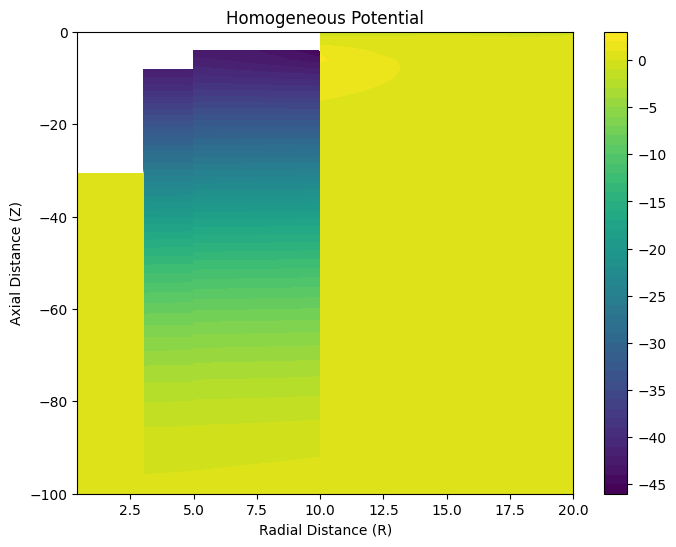

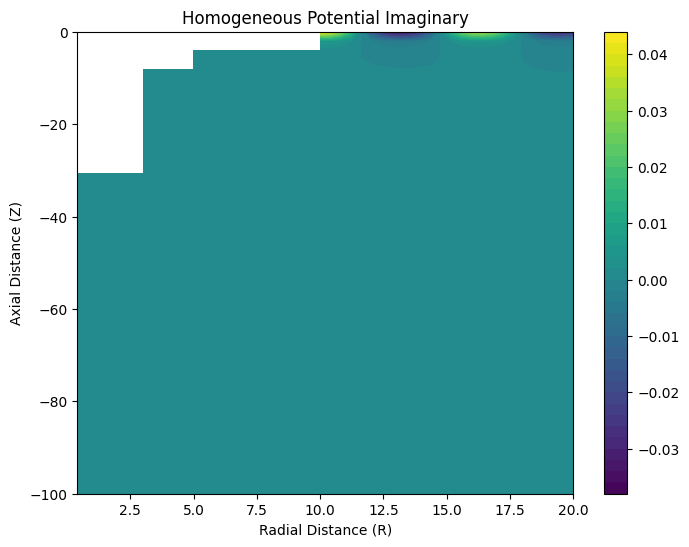

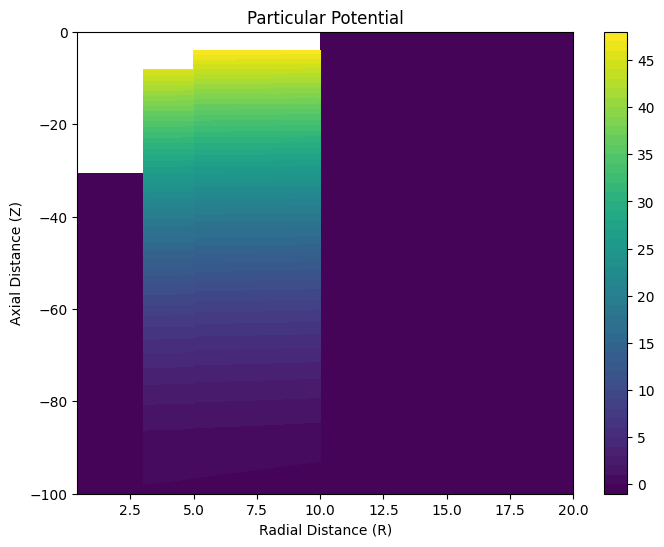

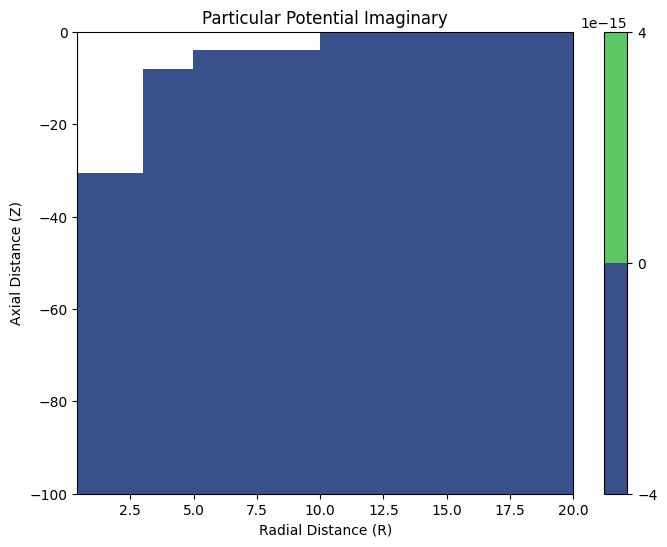

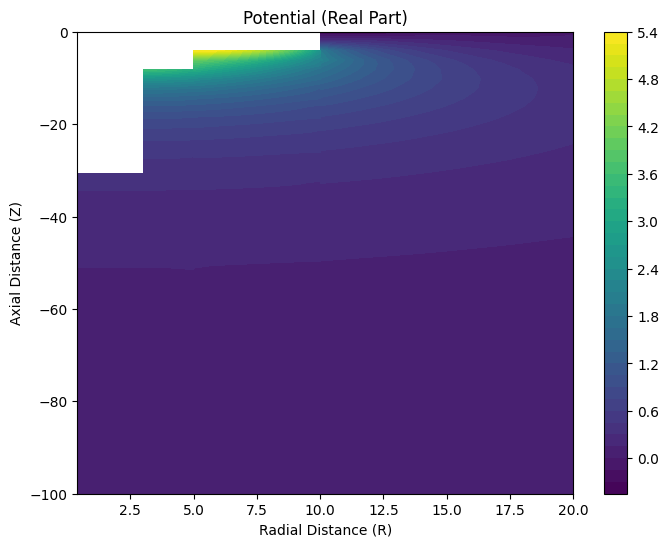

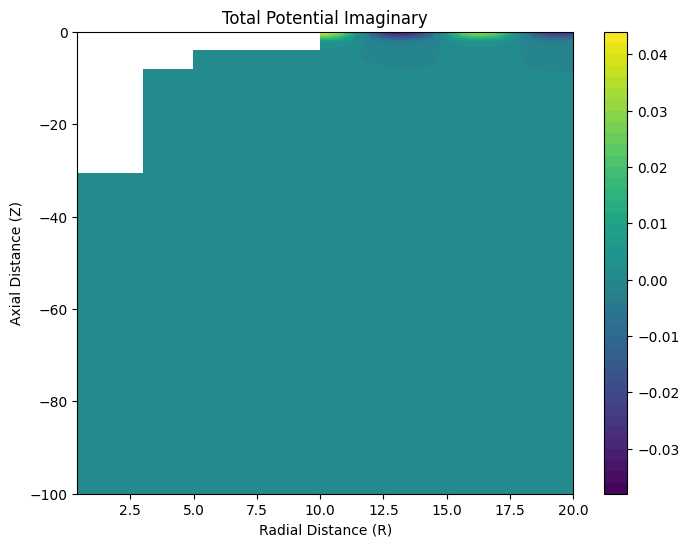

In [176]:
prob3 = Problem(100, [29, 7, 4], [3, 5, 10], [0, 1, 1], [50, 50, 50, 50], 1, 1023)
a3 = prob3.a_matrix()
b3 = prob3.b_vector()
x3 = prob3.get_unknown_coeffs(a3, b3)
cs3 = prob3.reformat_coeffs(x3)

am, dp = prob2.hydro_coeffs(x2, "capytaine")

print("Added Mass:", am)
print("Damping:", dp)

prob3.plot_potentials(cs3)

In [180]:
prob_alpha = Problem(100, [29, 4, 7], [3, 5, 10], [0, 1, 1], [7, 7, 7, 7], 1, 1023)
a_alpha = prob_alpha.a_matrix()
prob_beta = SProblem(100, [29, 4, 7], [29, 4, 7], [3, 5, 10], [0, 1, 1], [7, 7, 7, 7], 1, 1023)
a_beta = prob_beta.a_matrix()

ama, dpa = prob_alpha.hydro_coeffs(prob_alpha.get_unknown_coeffs(prob_alpha.a_matrix(), prob_alpha.b_vector()), "capytaine")
amb, dpb = prob_beta.hydro_coeffs(prob_beta.get_unknown_coeffs(prob_beta.a_matrix(), prob_beta.b_vector()), "capytaine")

print(ama, dpa)
print(amb, dpb)

1818182.6753566165 0.09697945311417784
1818182.6753566165 0.09697945311417784


In [ ]:
def solve_sproblem(h, d_in, d_out, a, heaving, NMK, m0, rho):
  prob = SProblem(h, d_in, d_out, a, heaving, NMK, m0, rho)
  a0 = prob.a_matrix()
  b0 = prob.b_vector()
  x = prob.get_unknown_coeffs(a0, b0)
  cs = prob.reformat_coeffs(x)

  am, dp = prob.hydro_coeffs(x, "capytaine")

  print("Added Mass:", am)
  print("Damping:", dp)

  prob.plot_potentials(cs)



Added Mass: 129.56943007380235
Damping: 102.50792632593009


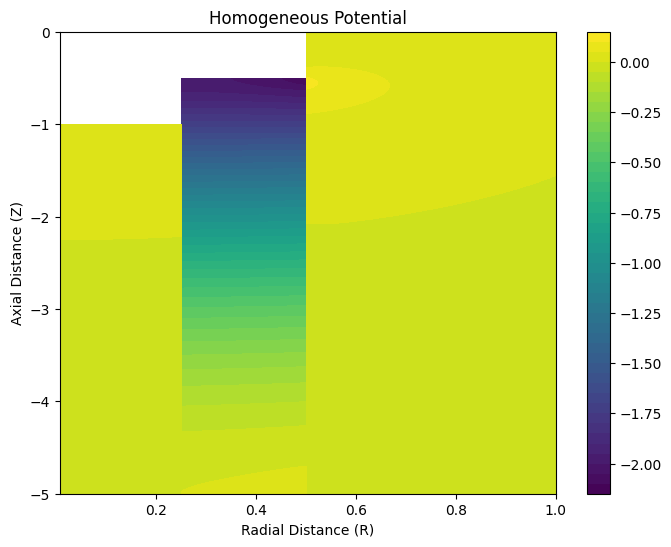

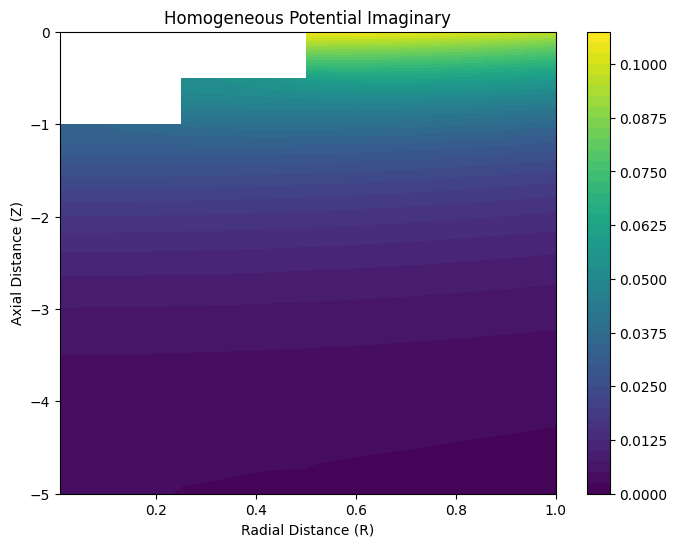

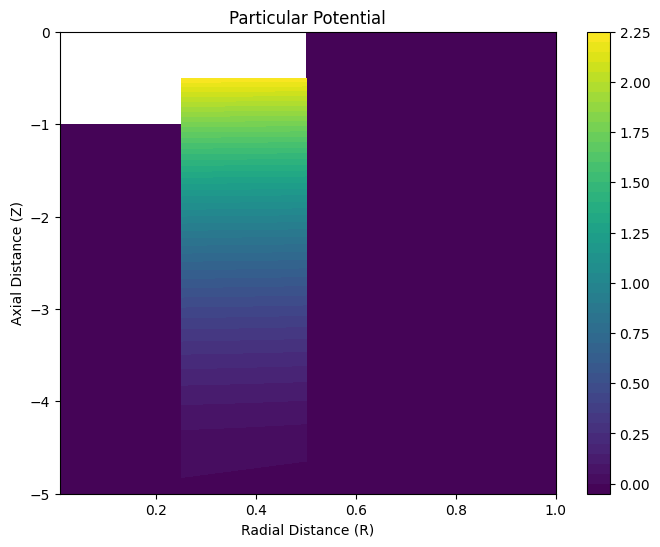

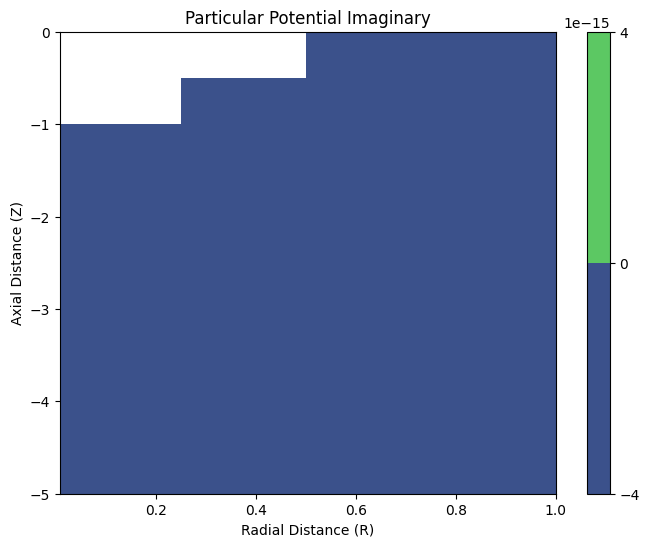

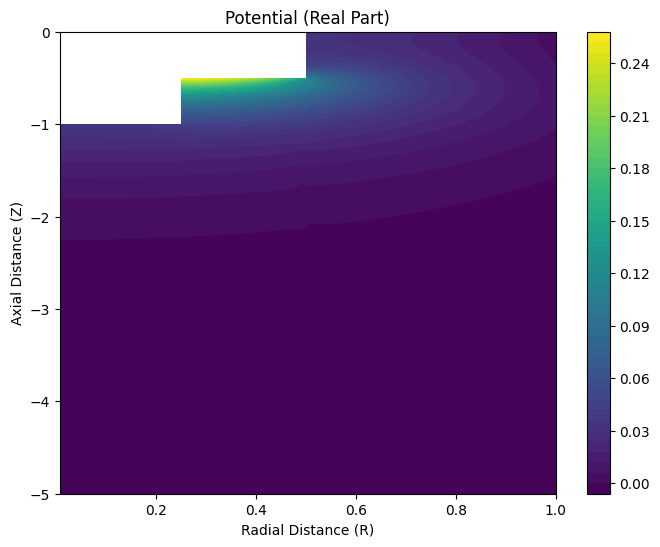

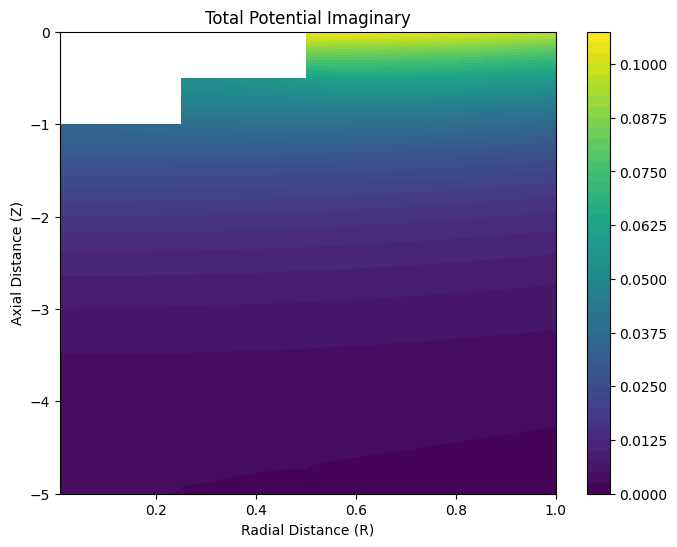

In [200]:
solve_sproblem(5, [1, 0.5], [1, 0.5], [0.25, 0.5], [0, 1], [50, 50, 50], 1, 1023)

Added Mass: 234.15201869624147
Damping: 92.83137354645868


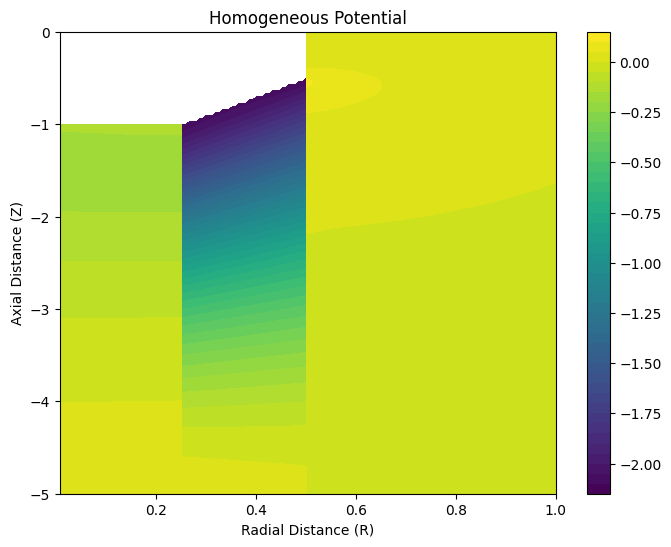

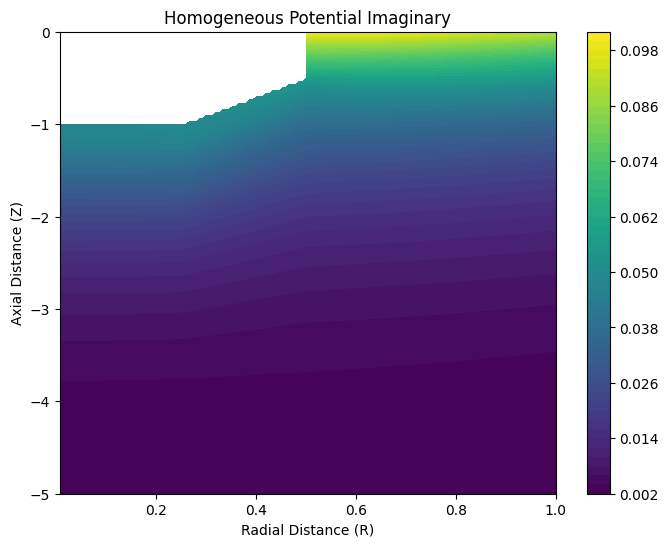

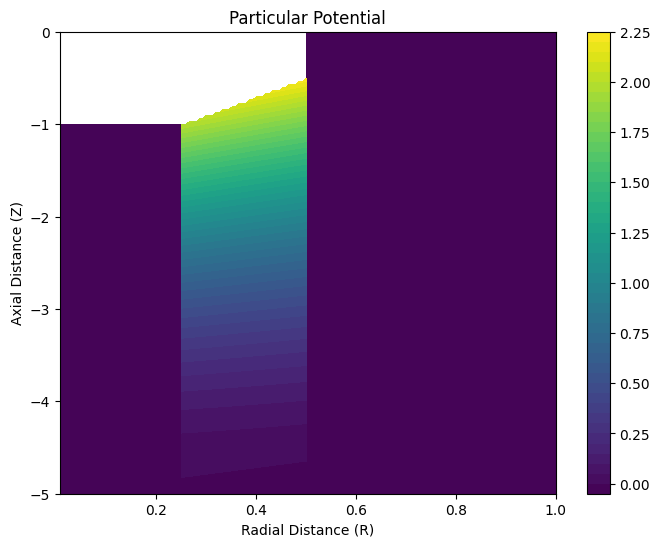

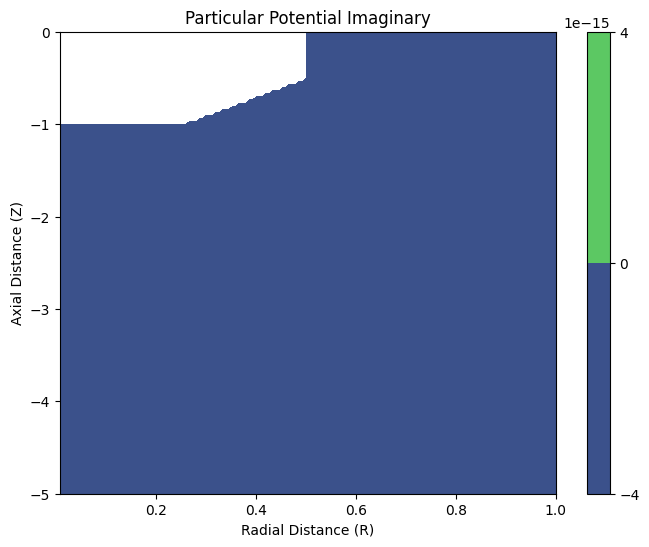

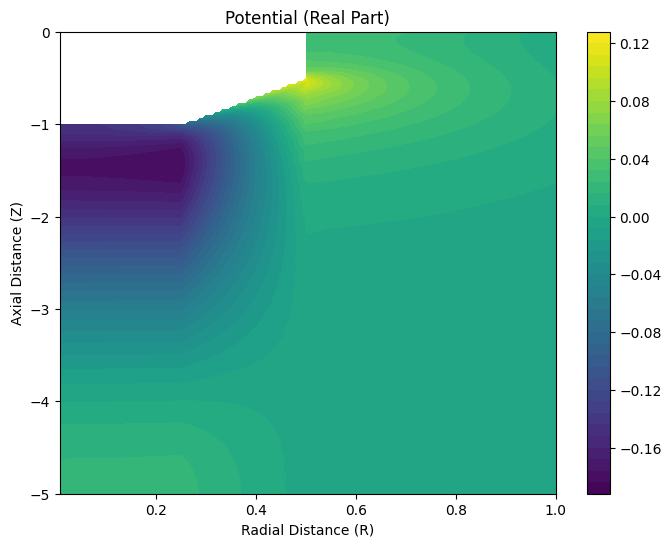

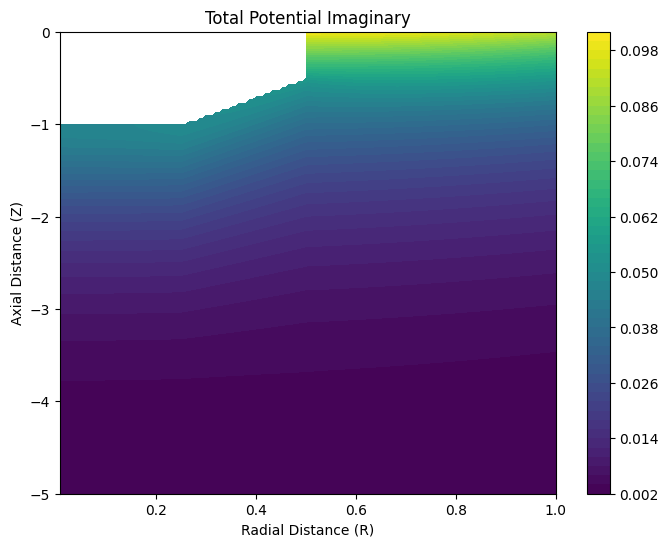

In [202]:
solve_sproblem(5, [1, 1], [1, 0.5], [0.25, 0.5], [0, 1], [50, 50, 50], 1, 1023)